In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
import seaborn

In [4]:
dfb = pd.read_csv('/Users/qasem/PycharmProjects/grad_ecc_RL_data/RL_behavior.csv')  # df behaviour

In [5]:
dfb.shape

(12170, 7)

In [6]:
dfb.head()

,Subject,Block,Trial,Score,ReactionTime,MovementTime,Valid
0,AB1,1,1,53.0,0.365009,0.182444,True
1,AB1,1,2,51.0,0.548555,0.402011,True
2,AB1,1,3,7.0,0.472627,0.269147,True
3,AB1,1,4,0.0,0.557651,0.289636,True
4,AB1,1,5,34.0,0.588884,0.211777,True


<AxesSubplot:xlabel='Block', ylabel='count'>

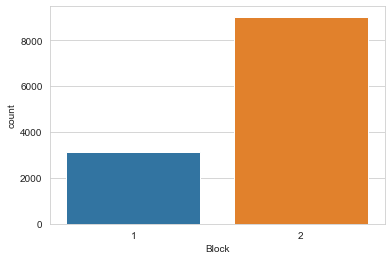

In [7]:
seaborn.countplot(data=dfb, x='Block')

In [8]:
# block 1 is baseline, 2 for learning (reward given)

In [9]:
dfb[dfb.Block==1].Trial.max()

70

In [10]:
dfb[dfb.Block==2].Trial.max()   # invalid. trial 200 is valid.

201

# task score in baseline and learning blocks

<AxesSubplot:xlabel='Trial', ylabel='Score'>

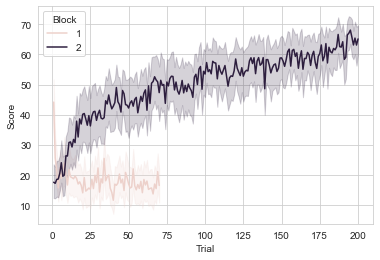

In [11]:
seaborn.lineplot(data=dfb, x='Trial', y='Score', hue='Block')

In [12]:
len_window = 30
df = dfb[dfb.Trial.isin(list(range(1,len_window+1)))].groupby(['Subject', 'Block']).Score.std()
df = df.rename('early_variability').reorder_levels([1,0])
df.head()

Block  Subject
1      AB1        17.603846
2      AB1        13.456588
1      AG1        13.700307
2      AG1        21.682891
1      AH1        16.554473
Name: early_variability, dtype: float64

# early variability correlate with subject score?
load subject overall score
fPCA or RLScore

In [13]:
# load score
fpca_scores = pd.read_csv('data/RLfpcaScores.csv').set_index('Subject')

In [14]:
fpca_scores.head()

,RLScore
Subject,
AB1,-1.179789
AG1,1.104018
AH1,-0.302101
AM1,-1.400917
AP1,0.868475


## fPCA

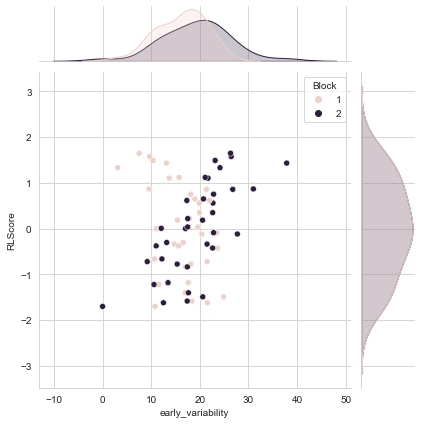

In [15]:
seaborn.jointplot(data=fpca_scores.join(df.to_frame()),
                 y='RLScore', x='early_variability', hue='Block')

In [16]:
from scipy import stats
def r2(data, x, y):   return stats.pearsonr(data[x], data[y])

### for learning block

<AxesSubplot:xlabel='early_variability', ylabel='RLScore'>

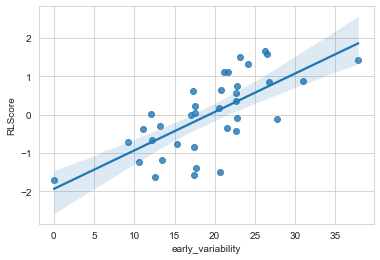

In [17]:
seaborn.regplot(data=fpca_scores.join(df.loc[2].to_frame()),
                 y='RLScore', x='early_variability')

In [18]:
r2(data=fpca_scores.join(df.loc[2].to_frame()),
                 y='RLScore', x='early_variability')

PearsonRResult(statistic=0.6995207689949621, pvalue=2.064310306146691e-06)

PearsonRResult(statistic=-0.3866202973481253, pvalue=0.019845838943560432)

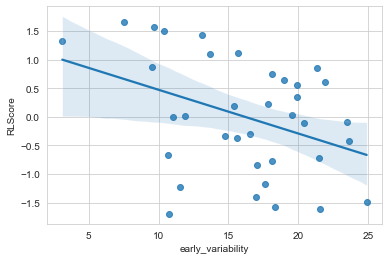

In [19]:
# for baseline block
seaborn.regplot(data=fpca_scores.join(df.loc[1].to_frame()),
                 y='RLScore', x='early_variability')
r2(data=fpca_scores.join(df.loc[1].to_frame()),
                 y='RLScore', x='early_variability')

In [20]:
# could be explained maybe task compliance

## mean late learning score
in contrast to fPCA score

### for learning block

In [21]:
len_window = 30

In [22]:
df_late_score = dfb[(dfb.Block==2) &
                    (dfb.Trial.isin(list(range(200-len_window, 201))))].groupby('Subject').Score.mean()
df_late_score = df_late_score.rename('late_score')

In [23]:
df_late_score.head()

Subject
AB1    49.230769
AG1    69.400000
AH1    46.384615
AM1    70.870968
AN1    30.933333
Name: late_score, dtype: float64

PearsonRResult(statistic=0.12831314070789754, pvalue=0.4009031380310894)

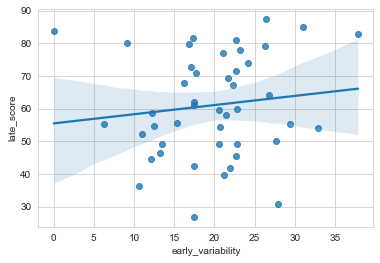

In [24]:
seaborn.regplot(data=df_late_score.to_frame().join(df.loc[2].to_frame()),
                 y='late_score', x='early_variability')
r2(data=df_late_score.to_frame().join(df.loc[2].to_frame()),
                 y='late_score', x='early_variability')

## shift in Score
how much she gets better.

### for learning block

In [25]:
len_window = 30

let's perform t-tests (paired=False) for subject's scores

In [26]:
from scipy import stats
def shift_subject(df_subject, len_window):
    end = df_subject.Trial.max()
    # in df_subject, get first `len_window` trials and last `len_window` trials
    # and put them into first and last lists
    first = df_subject[df_subject.Trial.isin(list(range(1,len_window+1)))].Score
    last = df_subject[df_subject.Trial.isin(list(range(end-len_window, end)))].Score
    # apply t-tests on first and last lists, paired=False
    return stats.ttest_ind(first, last, equal_var=False, nan_policy='omit')

In [27]:
# take subject 1 during learning (block=2)
# shift_subject(dfb[(dfb.Subject=='KP1') & (dfb.Block==2)])

In [28]:
# apply shift function to all subjects during learning, returning two values as two columns
df_shift = dfb[dfb.Block==2].groupby('Subject').apply(shift_subject, len_window=len_window).apply(pd.Series)
# rename as t and p
df_shift.columns = ['t', 'p']
df_shift.head()

,t,p
Subject,,
AB1,-10.482296,3.274779e-14
AG1,-5.387385,3.318213e-06
AH1,-2.316179,2.618057e-02
AM1,-11.321025,4.750898e-16
AN1,-0.113182,9.106734e-01


In [29]:
# show invalid subjects
df_shift[df_shift.p > 0.05]

,t,p
Subject,,
AN1,-0.113182,0.910673
HS1,-1.987685,0.052518
SH1,-1.068480,0.290370
SM1,-0.818882,0.416472
SS1,-1.772330,0.085145
TC1,-1.643061,0.107518


<AxesSubplot:xlabel='early_variability', ylabel='t'>

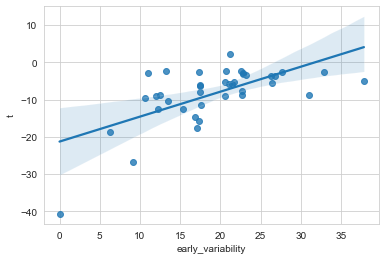

In [30]:
# plot shift vs early variability only for valid shifts
seaborn.regplot(data=df_shift[df_shift.p < 0.05].join(df.loc[2].to_frame()),
                 y='t', x='early_variability')

In [31]:
# make function to make shift score given len_window using shift_subject
def shift(dfb, len_window, only_valid=True):
    dfb = dfb[dfb.Block==2] # learning block
    df_shift = dfb.groupby('Subject').apply(shift_subject, len_window=len_window).apply(pd.Series)
    df_shift.columns = ['t', 'p']
    if only_valid:  df_shift = df_shift[df_shift.p < 0.05]
    return df_shift['t'].rename(f'shift_{len_window}').to_frame()

shift(dfb, 30).head()

,shift_30
Subject,
AB1,-10.482296
AG1,-5.387385
AH1,-2.316179
AM1,-11.321025
AP1,-8.632658


In [32]:
r2(data=df_shift[df_shift.p < 0.05].join(df.loc[2].to_frame()),
                 y='t', x='early_variability')

PearsonRResult(statistic=0.638221609155846, pvalue=1.2360709836110965e-05)

In [33]:
dfb[dfb.Block==1].groupby('Subject').apply(shift_subject, len_window=len_window).apply(pd.Series)

,0,1
Subject,,
AB1,-0.956376,3.432221e-01
AG1,-1.259133,2.133265e-01
AH1,0.106843,9.152830e-01
AM1,-0.861980,3.922620e-01
AN1,-0.252260,8.025037e-01
AP1,5.729598,4.193910e-07
AV1,2.721342,9.410231e-03
BN1,1.945138,5.891977e-02
CD1,-1.450085,1.526282e-01


number of invalid subjects: 30


PearsonRResult(statistic=-0.15628497530766725, pvalue=0.578064145757466)

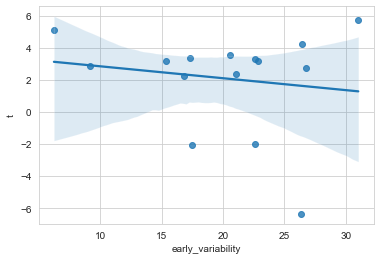

In [34]:
# repeat for baseline

df_shift = dfb[dfb.Block==1].groupby('Subject').apply(shift_subject, len_window=len_window).apply(pd.Series)
df_shift.columns = ['t', 'p']

print('number of invalid subjects:', len(df_shift[df_shift.p > 0.05]))

# in baseline, plot shift vs early variability only for valid shifts
seaborn.regplot(data=df_shift[df_shift.p < 0.05].join(df.loc[2].to_frame()),
                 y='t', x='early_variability')
# and get r2
r2(data=df_shift[df_shift.p < 0.05].join(df.loc[2].to_frame()),
                 y='t', x='early_variability')

# early versus late variability

In [35]:
# give early vs late data. param len_window.
# plot bar plots with data points shown and error bars

In [36]:
def variability(dfb, len_window):
    df = pd.DataFrame()
    df['early_variability'] = dfb[(dfb.Trial.isin(list(range(1,len_window+1))))&
        (dfb.Block==2)].groupby('Subject').Score.std()
    df['late_variability'] = dfb[(dfb.Trial.isin(list(range(200-len_window, 201))))&
        (dfb.Block==2)].groupby('Subject').Score.std()
    # adding str(window_len) to end of column names
    # df.columns = [f'{col}_{len_window}' for col in df.columns]
    return df

df = variability(dfb, 30)
df.head()

,early_variability,late_variability
Subject,,
AB1,13.456588,11.738169
AG1,21.682891,10.344414
AH1,13.186643,5.448500
AM1,17.646236,21.499987
AN1,27.892496,27.138446


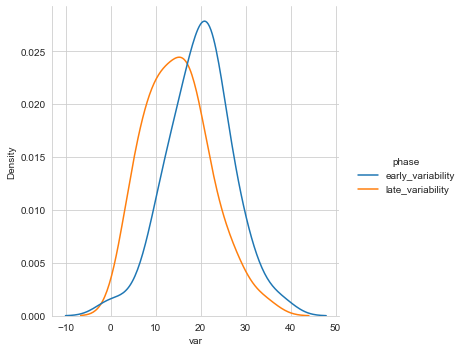

In [37]:
seaborn.displot(df.unstack().rename_axis(['phase','Subject']).rename('var').to_frame(),
                hue='phase', x='var', kind='kde')

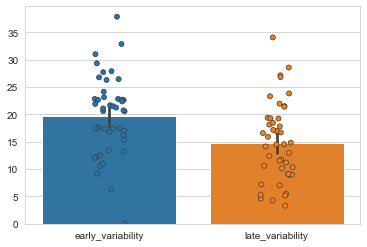

In [38]:
from matplotlib import pyplot as plt

# compare early and late variability in bar plot
# showing data points and error bars

seaborn.barplot(data=df)

# Draw the stripplot
seaborn.stripplot(data=df, linewidth=.75)

# save to svg file. filename includes str(len_window)
plt.savefig(f'variability-{len_window}.svg', bbox_inches='tight')

In [39]:
# paired t-test on early and late variability.
# alternative='less' means that we want to test if early variability is less than late variability
stats.ttest_rel(df.early_variability, df.late_variability, nan_policy='omit', alternative='greater')

Ttest_relResult(statistic=3.23299195560292, pvalue=0.0011622459108757805)

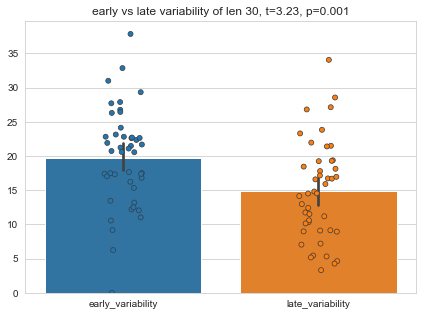

In [40]:
# make a function to plot early vs late variability with title
def plot_early_vs_late(dfb, len_window, save=False):
    df = variability(dfb, len_window)

    plt.figure(figsize=(7,5))
    seaborn.barplot(data=df)
    seaborn.stripplot(data=df, linewidth=.75)

    t, p = stats.ttest_rel(df['early_variability'], df['late_variability'],
                           nan_policy='omit', alternative='greater')
    title = f'early vs late variability of len {len_window}, t={t:.2f}, p={p:.3f}'
    plt.title(title)

    if save:    plt.savefig(f'variability-{title}.svg', bbox_inches='tight')

plot_early_vs_late(dfb, 30)

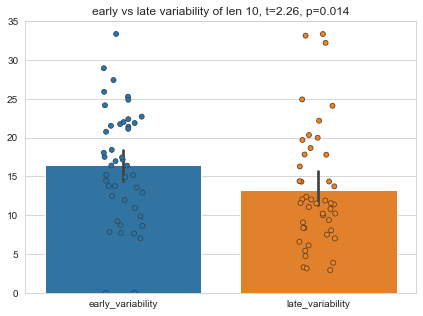

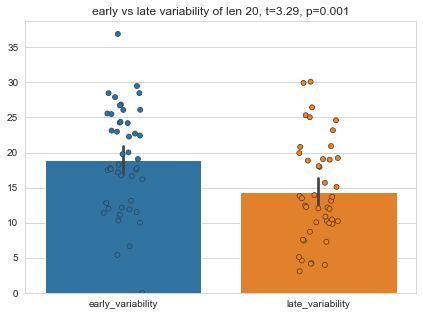

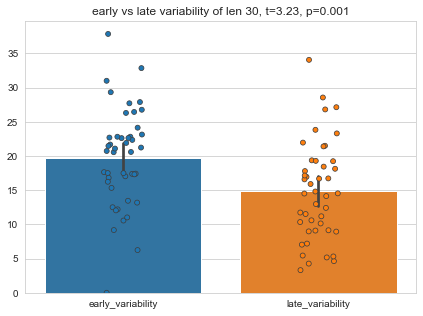

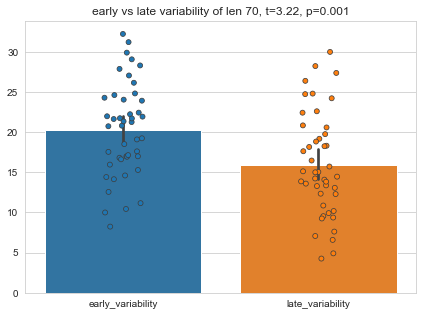

In [41]:
for len_window in [10, 20, 30, 70]:
    plot_early_vs_late(dfb, len_window, save=False)

early variability is more than late variability

# late variability correlates?

### for learning block

In [42]:
df.head()

,early_variability,late_variability
Subject,,
AB1,13.456588,11.738169
AG1,21.682891,10.344414
AH1,13.186643,5.448500
AM1,17.646236,21.499987
AN1,27.892496,27.138446


PearsonRResult(statistic=-0.4637019890770433, pvalue=0.004393504889250304)

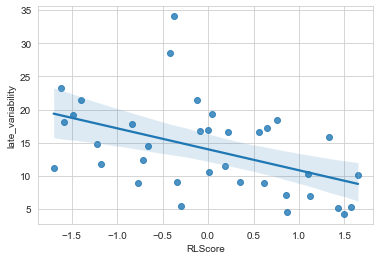

In [43]:
# in learning block, for late variability and fPCA score
seaborn.regplot(data=df.join(fpca_scores),
                 y='late_variability', x='RLScore')
r2(data=df.join(fpca_scores, how='inner'), y='late_variability', x='RLScore')

PearsonRResult(statistic=-0.5156037738054079, pvalue=0.00028921150466461093)

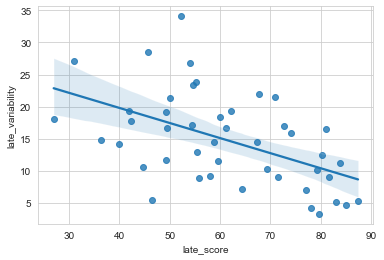

In [44]:
# in learning block, for late variability and mean late learning score
seaborn.regplot(data=df.join(df_late_score),
                 y='late_variability', x='late_score')
r2(data=df.join(df_late_score, how='inner'), y='late_variability', x='late_score')

means they're correlated and we can use late variability as a proxy for late learning score

PearsonRResult(statistic=-0.26526013833510825, pvalue=0.0782307653611724)

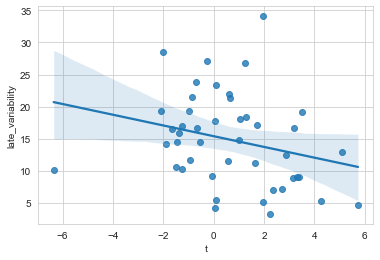

In [45]:
# in learning block, for late variability and shift
seaborn.regplot(data=df.join(df_shift), y='late_variability', x='t')
r2(data=df.join(df_shift, how='inner'), y='late_variability', x='t')

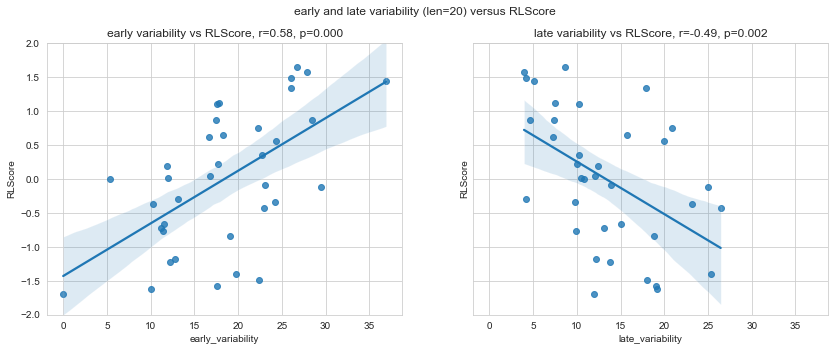

In [46]:
# plot early and late variability vs scores, side by side
def plot_early_vs_late(dfb, len_window, scores, save=False):
    score_name = scores.columns[0]
    df = variability(dfb, len_window)

    # make two subplots share x and y axes
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharex=True, sharey=True)
    # calculate r2 and add to subplot title
    r, p = r2(data=df.join(scores, how='inner'), y='early_variability', x=score_name)
    axes[0].set_title(f'early variability vs {score_name}, r={r:.2f}, p={p:.3f}')
    # set x and y axes limits
    axes[0].set_ylim(-2,2)
    # axes[0].set_xlim(0,40)
    seaborn.regplot(data=df.join(scores),
                     x='early_variability', y=score_name, ax=axes[0])

    r, p = r2(data=df.join(scores, how='inner'), y='late_variability', x=score_name)
    axes[1].set_title(f'late variability vs {score_name}, r={r:.2f}, p={p:.3f}')
    seaborn.regplot(data=df.join(scores),
                        x='late_variability', y=score_name, ax=axes[1])

    fig.suptitle(f'early and late variability (len={len_window}) versus {score_name}')

    if save:    plt.savefig(f'variability(len={len_window})-{score_name}.svg', bbox_inches='tight')

plot_early_vs_late(dfb, 20, fpca_scores)

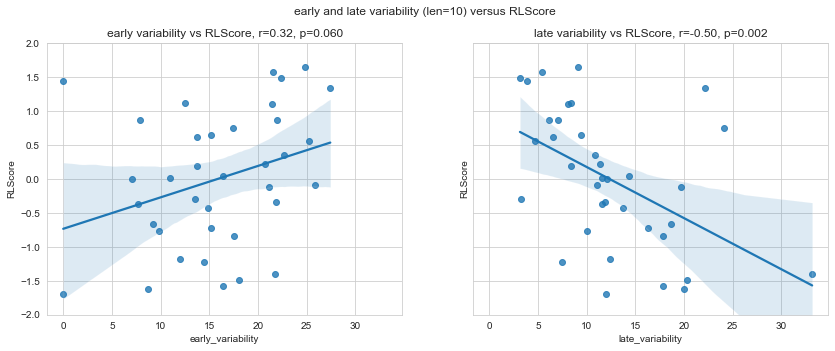

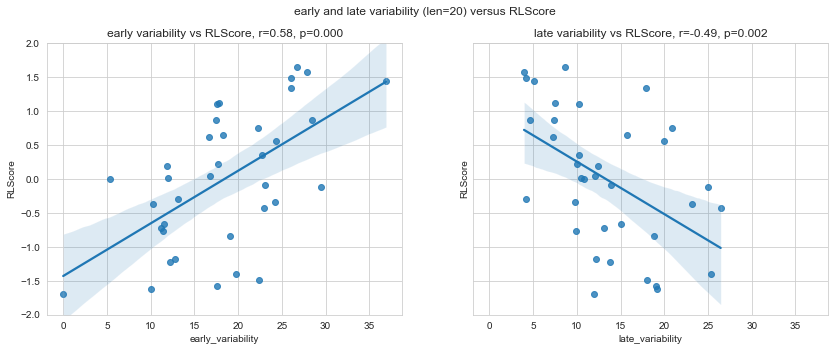

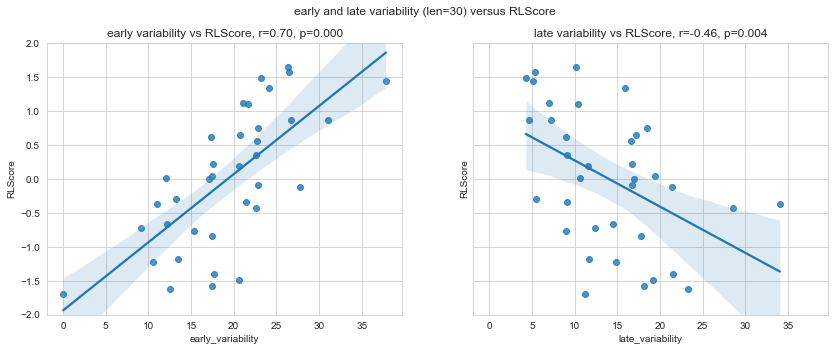

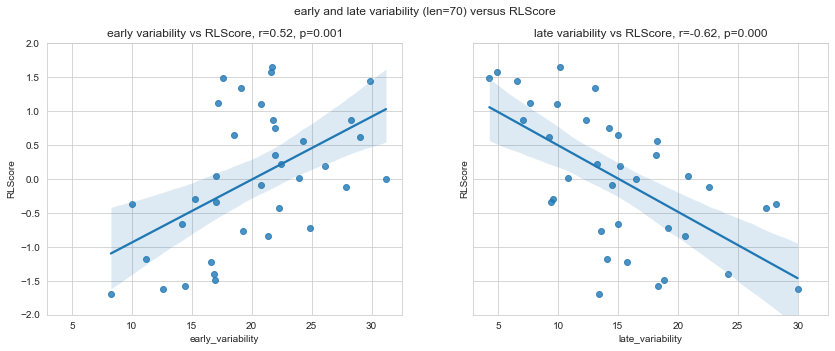

In [47]:
for len_window in [10, 20, 30, 70]:
    plot_early_vs_late(dfb, len_window, fpca_scores, save=False)
    # plot_early_vs_late(dfb, len_window, shift(dfb, len_window), save=False)

# early var correlates with brain data?

## expansion/contraction

In [48]:
# load brain data

def load_eccentricity():
    dfg = pd.read_csv('data/gradients.csv')  # df gradient values
    match = pd.read_csv('/Users/qasem/PycharmProjects/gradients-rl-task/data/participants.tsv', delimiter='\t')
    dff = pd.merge(dfg, match,
                   left_on='subject', right_on='participant_id', how='inner')  # df features
    dff = dff.rename(columns={'dicom_dir': 'Subject'})
    dff = dff.set_index(['subject', 'Subject', 'epoch', 'region', '7net', '17net'])[['ecc']].unstack(
        'epoch')  # make epochs differentiable
    dff = dff.droplevel(level=0, axis=1)
    dff['b2e'] = dff['early'] - dff['baseline']
    dff['e2l'] = dff['late'] - dff['early']
    dff['b2l'] = dff['late'] - dff['baseline']
    # dff = dff.reorder_levels([2, 3, 4, 0, 1])
    # dff.head()

    # df = dff.reset_index().merge(df_var, on='Subject', how='left')
    return dff#.set_index(['region', '7net', '17net', 'subject', 'Subject'])

In [49]:
df_ecc = load_eccentricity()
df_ecc.head()

epoch                                                       baseline  \
subject Subject region                   7net 17net                    
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  1.362379   
                7Networks_LH_Cont_Cing_2 Cont ContC         2.387077   
                7Networks_LH_Cont_Cing_3 Cont ContC         2.334831   
                7Networks_LH_Cont_Cing_4 Cont ContA         0.838871   
                7Networks_LH_Cont_Cing_5 Cont ContC         1.635923   

epoch                                                          early  \
subject Subject region                   7net 17net                    
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  2.389713   
                7Networks_LH_Cont_Cing_2 Cont ContC         2.642581   
                7Networks_LH_Cont_Cing_3 Cont ContC         2.671994   
                7Networks_LH_Cont_Cing_4 Cont ContA         2.075050   
                7Networks_LH_Cont_Cing_5 Cont ContC         1.971246   

epoch                                                           late  \
subject Subject region                   7net 17net                    
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  1.909058   
                7Networks_LH_Cont_Cing_2 Cont ContC         1.604613   
                7Networks_LH_Cont_Cing_3 Cont ContC         2.089021   
                7Networks_LH_Cont_Cing_4 Cont ContA         1.085350   
                7Networks_LH_Cont_Cing_5 Cont ContC         2.048514   

epoch                                                            b2e  \
subject Subject region                   7net 17net                    
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB  1.027334   
                7Networks_LH_Cont_Cing_2 Cont ContC         0.255503   
                7Networks_LH_Cont_Cing_3 Cont ContC         0.337163   
                7Networks_LH_Cont_Cing_4 Cont ContA         1.236179   
                7Networks_LH_Cont_Cing_5 Cont ContC         0.335323   

epoch                                                            e2l       b2l  
subject Subject region                   7net 17net                             
1       AB1     7Networks_LH_Cont_Cing_1 Cont SalVentAttnB -0.480655  0.546679  
                7Networks_LH_Cont_Cing_2 Cont ContC        -1.037968 -0.782465  
                7Networks_LH_Cont_Cing_3 Cont ContC        -0.582973 -0.245810  
                7Networks_LH_Cont_Cing_4 Cont ContA        -0.989700  0.246479  
                7Networks_LH_Cont_Cing_5 Cont ContC         0.077269  0.412591

cross correlation

### regions

In [50]:
from scipy.stats import pearsonr
def r_value(data, x, y):   return pearsonr(data[x], data[y])[0]
def p_value(data, x, y):   return pearsonr(data[x], data[y])[1]

In [51]:
import pingouin as pg

In [52]:
def cross_correlation(df, X, Y):
    # X = ['baseline', 'early', 'late', 'b2e', 'e2l']
    # Y = ['baseline_var', 'early_learning_var']
    l0=[]
    for y in Y:
        l1=[]
        for x in X:
            r = df.groupby(level='region').apply(r_value, x=x, y=y)    # grouped by region
            p = df.groupby(level='region').apply(p_value, x=x, y=y)
            _, pcorr = pg.multicomp(p, method='fdr_bh')
            pcorr = pd.Series(pcorr, index=p.index)
            l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
        l0.append(pd.concat(l1, axis=1, keys=X))
    return pd.concat(l0, axis=1, keys=Y)    # cross correlation

In [53]:
dfcr = cross_correlation(df_ecc.join(variability(dfb, 20), how='inner'),
                         X=['b2e', 'e2l'], Y=['early_variability', 'late_variability'])

In [54]:
dfcr.head()

early_variability                                \
                                       b2e                           e2l   
                                         r         p      pcor         r   
region                                                                     
7Networks_LH_Cont_Cing_1          0.021169  0.902468  0.980986 -0.143840   
7Networks_LH_Cont_Cing_2         -0.125681  0.465160  0.806660  0.233436   
7Networks_LH_Cont_Cing_3         -0.297729  0.077804  0.450071  0.222236   
7Networks_LH_Cont_Cing_4          0.073311  0.670897  0.904719 -0.049221   
7Networks_LH_Cont_Cing_5         -0.441573  0.007016  0.288460  0.310621   

                                             late_variability            \
                                                          b2e             
                                 p      pcor                r         p   
region                                                                    
7Networks_LH_Cont_Cing_1  0.402623  0.995184        -0.017339  0.920050   
7Networks_LH_Cont_Cing_2  0.170623  0.967970        -0.077060  0.655088   
7Networks_LH_Cont_Cing_3  0.192671  0.967970        -0.199278  0.243936   
7Networks_LH_Cont_Cing_4  0.775587  0.995184         0.021885  0.899184   
7Networks_LH_Cont_Cing_5  0.065204  0.953712         0.232371  0.172639   

                                                                  
                                         e2l                      
                              pcor         r         p      pcor  
region                                                            
7Networks_LH_Cont_Cing_1  0.988419  0.110582  0.520841  0.896505  
7Networks_LH_Cont_Cing_2  0.987689 -0.108435  0.529017  0.901288  
7Networks_LH_Cont_Cing_3  0.987689 -0.071354  0.679209  0.974977  
7Networks_LH_Cont_Cing_4  0.987689 -0.111318  0.518051  0.896505  
7Networks_LH_Cont_Cing_5  0.987689 -0.152270  0.375313  0.849702

In [55]:
# dfcr['early_learning_var']['baseline']['r'].head()

significant regions out of 1012 regions

In [56]:
p = dfcr.xs('pcor', axis=1, level=2)
(p<.05).sum().unstack()

,b2e,e2l
early_variability,0,0
late_variability,0,2


In [57]:
p = dfcr.xs('p', axis=1, level=2)
(p<.05).sum().unstack()

,b2e,e2l
early_variability,124,47
late_variability,29,59


In [59]:
# b2e = dfcr['early_learning_var']['b2e']
# b2e[b2e.p<.05]#.tail()

In [60]:
# baseline = dfcr['early_learning_var']['baseline']
# baseline[baseline.p<.05].tail()

plotting on brain

In [61]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]
region_names = pd.read_csv('data/regions_sorted.csv')['region']

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [62]:
# cortex

def plot_cross_correlation(dfcr, e, metric, save=False):
    data = dfcr[metric][e]

    data1 = data['r']
    data1 = data1.loc[region_names]
    data1 = map_to_labels(data1, vertices, mask=(vertices != 0))
    fname = e + ' ecc vs ' + metric
    p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='grid', size=(900, 700), label_text=[fname])

    p.add_layer(data1, cbar=True, cmap='bwr', color_range=(-.6,.6))

    # seed region outlined
    data2 = (data['p']<.05).loc[region_names]
    data2 = map_to_labels(data2, vertices, mask=(vertices != 0))
    p.add_layer(data2, cbar=False, as_outline=True, cmap='binary')

    figure = p.build()
    if save:    figure.savefig(fname+'.png', dpi=300)

# plot_cross_correlation(dfcr, 'b2e', 'early_variability')

In [97]:
X = ['b2e', 'e2l']
Y = ['early_variability', 'late_variability']

for window_len in [10, 20, 30, 70]:
    break
    df_cross_window = cross_correlation(df_ecc.join(variability(dfb, window_len), how='inner'), X=X, Y=Y)
    for y in Y:
        for x in X:
            plot_cross_correlation(df_cross_window, x, y, save=False)

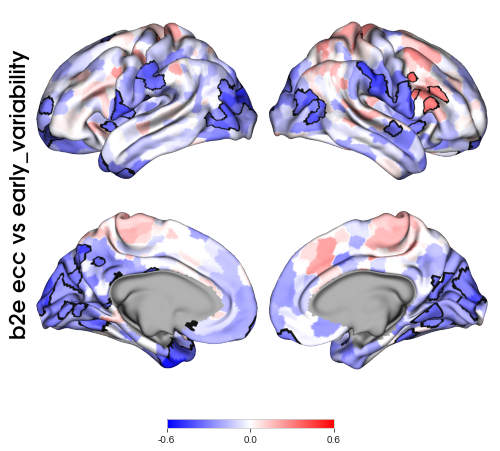

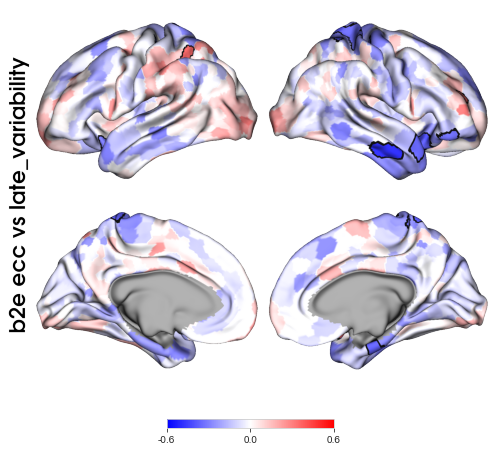

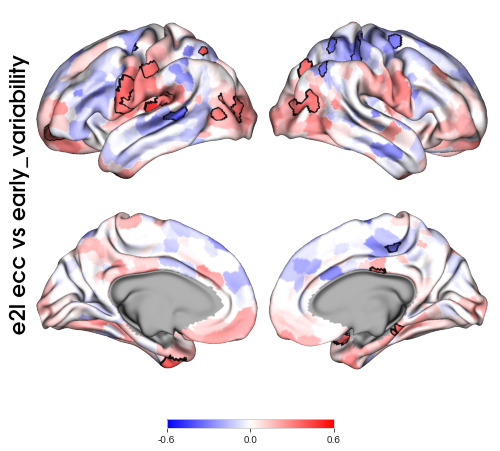

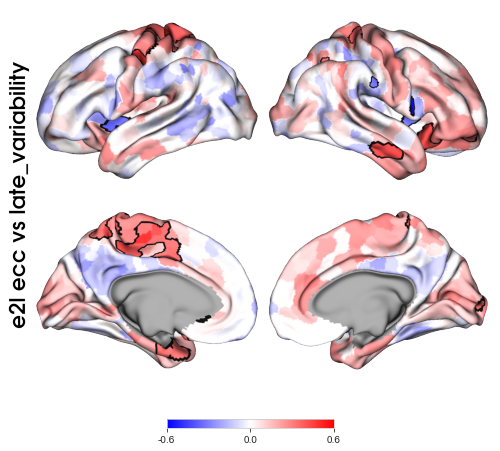

In [66]:
X = ['b2e', 'e2l']
Y = ['early_variability', 'late_variability']
dfcr = cross_correlation(df_ecc.join(variability(dfb, 20), how='inner'), X=X, Y=Y)

for e in X:
    for m in Y:
        plot_cross_correlation(dfcr, e, m, save=False)

### subcortex

In [92]:
# significant regions cross correlations. p < 0.05
pvals = dfcr.xs('p', axis=1, level=2) < .05
pvals.sum().unstack()
# out of 1012 regions:

,b2e,e2l
early_variability,124,47
late_variability,29,59


In [93]:
# only in subcortex. last 14 rows
pvals = dfcr.tail(14).xs('p', axis=1, level=2) < .05
pvals.sum().unstack()
# out of 14 regions:

,b2e,e2l
early_variability,0,0
late_variability,2,4


plot

In [99]:
subcortex_order = ['Left Accumbens',
                     'Left Amygdala',
                     'Left Caudate',
                     'Left Hippocampus',
                     'Left Pallidum',
                     'Left Putamen',
                     'Left Thalamus',
                     # 'Left Ventricles',
                     'Right Accumbens',
                     'Right Amygdala',
                     'Right Caudate',
                     'Right Hippocampus',
                     'Right Pallidum',
                     'Right Putamen',
                     'Right Thalamus',
                     # 'Right Ventricles',
                   ]

# to reorder data regarding function input
# array_name = data.loc[subcortex_order]
# two values removed, ventricles must set False

In [116]:
from enigmatoolbox.plotting import plot_subcortical

def plot_subcortical_cross_correlation(dfcr, e, metric, save=False):
    fname = f'{e} ecc vs {metric}'
    data = dfcr[metric][e]
    data = data['r']
    data = data.loc[subcortex_order]

    plot_subcortical(data, ventricles=False,
                     size=(800, 400), cmap='bwr', color_bar=True,
                     color_range=(-0.6, 0.6), interactive=False,
                     screenshot=save, filename=f'subcortical {fname}.png',
                     # to save it, pass both screenshot as True and filename
                     )

In [117]:
for m in ['early_variability', 'late_variability']:
    for e in ['b2e', 'e2l']:
        plot_subcortical_cross_correlation(dfcr, e, m, save=True)

### networks

In [ ]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['baseline_var', 'early_learning_var']
l0=[]
for y in Y:
    l1=[]
    for x in X:
        r = df.groupby(level='7net').apply(r_value, x=x, y=y)    # grouped by '7net'
        p = df.groupby(level='7net').apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfcr7 = pd.concat(l0, axis=1, keys=Y)    # cross correlation

out of 8 networks

In [ ]:
p = dfcr7.xs('pcor', axis=1, level=2)
(p<.05).sum().unstack()

17 networks

In [ ]:
X = ['baseline', 'early', 'late', 'b2e', 'e2l']
Y = ['baseline_var', 'early_learning_var']
l0=[]
for y in Y:
    l1=[]
    for x in X:
        r = df.groupby(level='17net').apply(r_value, x=x, y=y)    # grouped by '17net'
        p = df.groupby(level='17net').apply(p_value, x=x, y=y)
        _, pcorr = pg.multicomp(p, method='fdr_bh')
        pcorr = pd.Series(pcorr, index=p.index)
        l1.append(pd.concat([r, p, pcorr], axis=1, keys=['r', 'p', 'pcor']))
    l0.append(pd.concat(l1, axis=1, keys=X))
dfcr17 = pd.concat(l0, axis=1, keys=Y)    # cross correlation

out of 19 networks

In [ ]:
p = dfcr17.xs('pcor', axis=1, level=2)
(p<.05).sum().unstack()